In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.stats import ttest_ind, ttest_1samp, fisher_exact
import scipy
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

DATADIR = '../data/' # directory that contains the anonymized data

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [6]:
def assignRegion(row):
    
    if row.region == 'Americas':
        if row['sub-region'] == 'Northern America':
            return 'NA and Oceania'
        else:
            return row['sub-region']
        
    elif row.region == 'Oceania': return 'NA and Oceania'
    else:
        return row.region

### map from iso code to country names ###
isoToC = (
    pd.read_csv(DATADIR + 'worldcities.csv',usecols=['iso2','country'])
    .drop_duplicates()
    .rename(columns={'iso2':'iso'})
)
isoToC.loc[isoToC.iso == 'US', 'country'] = 'U.S.A.' # replace country name w/ abbreviation USA
isoToC.loc[isoToC.iso == 'AE', 'country'] = 'U.A.E.' # replace country name w/ abbreviation UAE
isoToC.loc[isoToC.iso == 'GB', 'country'] = 'U.K.' # replace country name w/ abbreviation UK

assert(isoToC.iso.duplicated().any() == False)
assert(isoToC.country.duplicated().any() == False)
### ###

### map from ISO codes to regions 
continents = (
    pd.read_csv(DATADIR + 'continents2.csv',usecols=['iso_3166-2','region','sub-region'])
    .rename(columns={'iso_3166-2':'iso'})
    .assign(iso=lambda df: df.iso.apply(lambda x: x.replace('ISO 3166-2:','')))
    .drop_duplicates()
    .dropna()
    .assign(region=lambda df: df.apply(assignRegion, axis=1))
    .drop('sub-region', axis=1)
)
print(isoToC.shape, continents.shape)
### ###

### color of countries ###
colorsDf = pd.DataFrame({
    'region': ['Africa', 'Latin America and the Caribbean', 'Asia', 'Europe', 'NA and Oceania'], 
    'Color': ['#f34d4d', '#f34d4d', '#f34d4d', '#69bade', '#69bade']}) # white and non-white colors

colors = dict(zip(colorsDf.region, colorsDf.Color))
###

(223, 2) (248, 2)


In [2]:
publisherToID = pd.read_csv(DATADIR + "PublisherId.csv",sep='\t')

authors = (
    pd.read_csv(DATADIR + 'country_rep/Authors.tsv', sep='\t')
    .merge(publisherToID, on='PubID')
)

editors = (
    pd.read_csv(DATADIR + 'country_rep/Editors.tsv', sep='\t')
    .merge(publisherToID, on='PubID')
)

In [3]:
def computeRepresentation(authors, editors, unifyBaseline=False):
    
    # keys of dataframe: publisher, country
    # If unifyBaseline==True: use all authorships as the baseline
    
    byPubAu = authors.groupby(['Publisher']).iso.value_counts(normalize=True).reset_index(name='AuthorPercent')
    byPubEd = editors.groupby(['Publisher']).iso.value_counts(normalize=True).reset_index(name='EditorPercent')

    both = byPubEd.merge(byPubAu, on=['Publisher','iso'], how='left').fillna({'EditorPercent': 0})
    print('countries that exist among both authors and editors', both.shape)  # 564
    

    df = pd.DataFrame(columns=['iso', 'Over', 'p', 'EdiCount', 'AutCount', 'EdiTotal', 'AutTotal'])
    df['Over'] = df['Over'].astype(bool)

    for publisher in tqdm(['pnas', 'ieee', 'mdpi', 'plos', 'hindawi', 'frontiers', 'all']):
    
        if publisher != 'all':
            subEdi = editors.query(f'Publisher == "{publisher}"')
            subAut = authors.query(f'Publisher == "{publisher}"')
        elif publisher == 'all':
            subEdi = editors.copy()
            subAut = authors.copy()
            
        if unifyBaseline: subAut = authors.copy()

        ediTotal = subEdi.shape[0]
        autTotal = subAut.shape[0]
        
        if ediTotal==0 or autTotal==0: continue

        for country in both.iso.unique():

            e = subEdi.query(f'iso == "{country}"').shape[0]
            a = subAut.query(f'iso == "{country}"').shape[0]

            test = fisher_exact([[e, ediTotal], [a, autTotal]])
            
            df = pd.concat([df, pd.DataFrame({
                'Publisher': publisher,
                'iso':country,
                'Over': bool(e/ediTotal > a/autTotal),
                'p': test[1],
                'EdiCount': e,
                'AutCount': a,
                'EdiTotal': ediTotal,
                'AutTotal': autTotal
            }, index=[0])], ignore_index=True, sort=False)
            
    df = df.assign(EdiPercent = lambda df: df.EdiCount/df.EdiTotal)
    df = df.assign(AutPercent = lambda df: df.AutCount/df.AutTotal)
    
    print(df.shape)
    df = df.query('AutPercent > 0')
    df = df.assign(Relative = lambda df: df.EdiPercent/df.AutPercent)
    
    print(df.shape)
    
    return df

In [4]:
%%time
df = computeRepresentation(authors, editors, False)

countries that exist among both authors and editors (564, 4)


  0%|          | 0/7 [00:00<?, ?it/s]

(1015, 10)
(963, 11)
CPU times: user 1min 8s, sys: 2.55 s, total: 1min 10s
Wall time: 1min 10s


In [7]:
(
    df.query('Publisher == "all"')
    .merge(continents, on='iso')
    .merge(colorsDf, on='region')
    .groupby('Color').agg({'EdiCount':sum, 'AutCount':sum})
)
# 624469	2888833
# 148254	1945467

,EdiCount,AutCount
Color,,
#69bade,624469,2888833
#f34d4d,148254,1945467


In [8]:
assert((df[df.Publisher == "all"].EdiTotal == df.query('Publisher == "all"').EdiCount.sum()).all()==True)

## Figure 1b

In [9]:
toPlot = (
    df
    
    .merge(continents, on='iso')
    .merge(isoToC, on='iso')
    .merge(colorsDf, on='region')
)

In [10]:
print(
    toPlot.query(f'Publisher == "all"')
    .sort_values(by='AutPercent',ascending=False)
    [['country','EdiPercent','AutPercent','Relative']]
    .head(10) # remove this to see the full table
    
    .assign(EdiPercent = lambda df: df.EdiPercent.apply(lambda x: f'{round(x*100, 4)}%'))
    .assign(AutPercent = lambda df: df.AutPercent.apply(lambda x: f'{round(x*100, 4)}%'))
    .assign(Relative = lambda df: df.Relative.apply(lambda x: f'{round(x, 2)}'))
    
    .rename(columns={'country':'Country', 'EdiPercent':'% editors', 'AutPercent':'% authors', 'Relative':'% editors / % authors'})
    .style.to_latex()
)

\begin{tabular}{lllll}
 & Country & % editors & % authors & % editors / % authors \\
6 & U.S.A. & 36.8091% & 22.1546% & 1.66 \\
57 & China & 7.5205% & 21.6074% & 0.35 \\
346 & Germany & 3.7866% & 5.1118% & 0.74 \\
339 & U.K. & 7.1077% & 4.7419% & 1.5 \\
332 & Italy & 7.809% & 3.9166% & 1.99 \\
64 & Japan & 2.5391% & 3.6518% & 0.7 \\
360 & France & 2.7934% & 3.2856% & 0.85 \\
353 & Spain & 3.0464% & 2.6853% & 1.13 \\
20 & Canada & 3.295% & 2.5759% & 1.28 \\
13 & Australia & 4.3109% & 2.5642% & 1.68 \\
\end{tabular}



In [11]:
def plotFigure1(df, ax):
    
    print(df.shape)
    df = df.query('p < 0.001')
    print(df.shape, 'Only show significantly over/under')
    
    posNeg = lambda x: x-1 # transform into positive or negative
    
    countries = df.iso
    x = [_ for _ in range(len(countries))]
    y = df.Relative.apply(posNeg)
    
    ax.set_xticks([])
    
    df= df.reset_index(drop=True).reset_index()
    for ind, row in df.iterrows():
        
        if row['Relative'] > 1:
            ax.text(ind, -0.01, row['country'], rotation='vertical', ha='center', va='top')
            
        elif row['Relative'] < 1:
            ax.text(ind, 0.1, row['country'], rotation='vertical', ha='center', va='bottom')
    
    ax.bar(x, y, color=df.Color)
    
    
    yticks = ax.get_yticks()
    ax.set_yticks(yticks)

    ax.set_yticklabels([f"{x+1:g}" for x in ax.get_yticks()])

(42, 14)
(41, 14) Only show significantly over/under


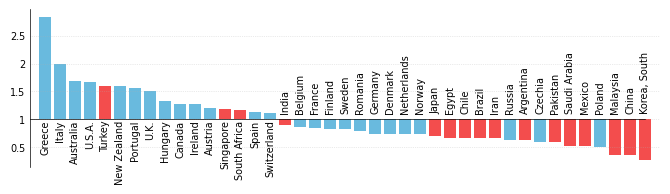

In [12]:
ax = plt.gca()

plotFigure1(
    toPlot.query('Publisher == "all"')
    .query('EdiCount > 1000')
    .sort_values(by='Relative', ascending=False), 
    ax
)

ax.set_xlim(-1, 41)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False) 
ax.spines['right'].set_visible(False)

ax.tick_params(length=0)
ax.grid(visible=True, ls=':', axis='y', alpha=0.5)

ax.plot([-1, 40], [0, 0], color='black', lw=0.5)

set_size(16*cm, 4*cm, ax)

plt.savefig('../figures/figure_1b.pdf',bbox_inches = 'tight', pad_inches = 0)

## Figure 1a

In [13]:
import math

In [14]:
toPlot = (
    df
    
    .merge(continents, on='iso')
    .merge(isoToC, on='iso')
    .merge(colorsDf, on='region')
)

In [16]:
iso2to3 = (
    pd.read_csv(DATADIR + 'worldcities.csv',usecols=['iso2','iso3'])
    .drop_duplicates()
    .rename(columns={'iso2':'iso'})
)
assert(iso2to3.iso3.duplicated().any() == False)
assert(iso2to3.iso.duplicated().any() == False)

print(iso2to3.shape) # 223

(223, 2)


In [17]:
colorSeq = [
    '#543005',
    '#8c510a',
    '#bf812d',
    '#dfc27d',
    '#f6e8c3',
    '#c7eae5',
    '#80cdc1',
    '#35978f',
    '#01665e',
    '#003c30'
]

colorSeq = colorSeq
len(colorSeq)

10

In [18]:
def assignColor(row, col, baseline):
    try:
        diff = baseline-int(row[col]) # difference between the current bin and the baseline bin
        assert(4-diff >=0 and 4-diff < 10) # 10 being the total number of colors
        
        return colorSeq[4 - diff] # 4 is the index of the last green color
    except Exception as e:
        
        print('ERROR', e)
        return np.nan

In [19]:
import geopandas

def produceMap(pub):
    
    representation = toPlot.query(f'Publisher == "{pub}"')[['iso','Relative','p']]
    print(representation.shape)

    path_to_data = geopandas.datasets.get_path("naturalearth_lowres")
    world = (
        geopandas.read_file(path_to_data)
        .rename(columns={'iso_a3':'iso3'})
        .drop(['pop_est', 'gdp_md_est'], axis=1)
    )
    print(world.shape)

    world.loc[world.name == 'Taiwan', 'iso3'] = 'CHN'
    world.loc[world.name == 'Norway', 'iso3'] = 'NOR'
    world.loc[world.name == 'France', 'iso3'] = 'FRA'
    world = world[world.continent != 'Antarctica']
    world = world.drop(['continent'], axis=1)
    print('Remove Antarctica', world.shape)

    world = world.query('iso3 != "-99"')
    print('Remove unrecognized countries', world.shape)

    world = world.dissolve(by='iso3').reset_index()
    print('One China', world.shape)

    world = (
        world.merge(iso2to3, on='iso3')
        .merge(representation, on='iso')
    )
    print(world.shape)
    
    return world

In [20]:
def getPercentile(df, col, N, cutoff=None):
    
    # N: number of percentile bins
    # cutoff: below and above cutoff should be two different colors
    
    df = (
        df
        .assign(percentile = lambda df: 
                  df[col].rank(pct=True, method='max')
                  .apply(lambda x: math.ceil((x*N))) # round up percentile score
                 )
        .rename(columns={'percentile': f'{col}_Q'})
    )
    binsDf = None
    
    if cutoff is not None:
        
        # split the bin that contains cutoff into 2
        
        bins = df.groupby(f'{col}_Q')[col].max().reset_index().set_index(f'{col}_Q').to_dict()[col]
        
        ### add 1 as a bin cutoff, and shift all following bin index by 1 ###
        prev = None
        midInd = None # index of the last bin below cutoff
        
        for i in range(min(bins.keys()), N+1):
            if bins[i] > cutoff:
                if prev is None:
                    midInd = i
                    prev=bins[i]
                    bins[i] = cutoff
                else:
                    bins[i], prev = prev, bins[i]
        bins[N+1] = prev
        
        binsDf = (
            pd.DataFrame.from_dict(bins, orient='index', columns=[f'{col}_max'])
            .reset_index().rename(columns={'index': f'{col}_Q'})
            .assign(Color = lambda df: df.apply(lambda row: assignColor(row, f'{col}_Q', baseline=midInd), axis=1))
        )
        ######
        
        df = df.drop([f'{col}_Q'], axis=1)
        cols = df.columns.to_list()
        
        df = (
            df
            .assign(key=1).merge(binsDf.assign(key=1), on='key')
            .query(f'{col} <= {col}_max')
            .groupby(cols)[f'{col}_Q'].min().reset_index()
            
            .merge(binsDf[[f'{col}_Q', 'Color']], on=f'{col}_Q')
        )
    
    return df, binsDf

In [21]:
def plotMap(publisher, ax=None, numBins=5, cax=None, figsize=(24*cm, 6*cm)):
    
    world = produceMap(publisher)

    relativeBins, bins = getPercentile(
        world.query('p < 0.001')[['iso3','Relative']],
        'Relative', 5, 1
    )
    
    #return relativeBins, bins
    
    assert(relativeBins.shape[0] ==  world.query('p < 0.001').shape[0])
    if numBins + 1 != bins.shape[0]:
        print('warning! number of bins', bins.shape[0])

    world = (
        pd.concat([
            world.query('p < 0.001').merge(relativeBins.drop(['Relative'], axis=1), on='iso3'),
            world.query('p >= 0.001').assign(Color='lightgrey')
        ], ignore_index=True, sort=False)
    )

    print(world.shape, 'should be the same as before')
    
    if ax is None: ax = plt.gca()

    set_size(figsize[0], figsize[1], ax)

    world.plot(ax = ax, color=world.Color)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if cax is not None:
        plotPallete(bins.Color, list(bins.Relative_max), cax, vertical=True, scale=0.6)
        

    plt.savefig(f'../figures/figure_1a.pdf',bbox_inches = 'tight', pad_inches = 0)
    
    return bins

In [22]:
def plotPallete(cSeq, labels, ax=None, vertical=False, scale=1, rounding=1):
    
    n = len(cSeq)
    labels = [0] + labels
    
    if vertical:
        if ax is None:
            
            ax = plt.gca()
            set_size(1*cm*scale, n*cm*scale)
    
        ax.set_ylim(0, n)
        ax.set_xlim(0, 1)
        ax.set_xticks([])
        
        ax.set_yticks([x for x in range(n+1)])
        ax.set_yticklabels([f"{round(x, rounding):g}" for x in labels])
        
        for i in range(n):
            ax.fill_between([0, 1], i, i+1, facecolor=cSeq[i])

(145, 3)
(177, 4)
Remove Antarctica (176, 3)
Remove unrecognized countries (173, 3)
One China (172, 3)
(134, 6)
(134, 8) should be the same as before


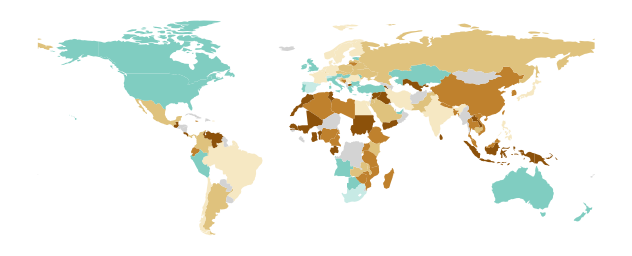

In [23]:
bins = plotMap('all')

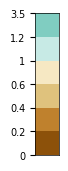

In [24]:
plotPallete(bins.Color, list(bins.Relative_max), vertical=True, scale=0.6)

plt.savefig('../figures/figure_1a_legend.pdf', bbox_inches = 'tight', pad_inches = 0)

## Figure 1c, 1d, and 1e

In [25]:
def plotSidebySide(toPlotDf, key='FieldName', hspace=1, width=10, height=6, saveFile=True):
    
    bars = toPlotDf.groupby([key,'Color']).Over.value_counts(normalize=True).reset_index(name='Percentage')
    
    sequence = (
        bars.query('Over == True').query('Color == "#69bade"')
        .sort_values(by='Percentage',ascending=False)
        [[key]]
    )
    
    offset=0.1
    
    xRed = [_*2+offset for _ in range(sequence.shape[0])]
    xBlue = [_*2+1-offset for _ in range(sequence.shape[0])]
    
    overBlue = (
        bars.query('Over == True').query('Color == "#69bade"')
        .merge(sequence, how='right', on=key).fillna({'Percentage':0})
    )
    overRed = (
        bars.query('Over == True').query('Color == "#f34d4d"')
        .merge(sequence, how='right', on=key).fillna({'Percentage':0})
    )
    
    underBlue = (
        bars.query('Over == False').query('Color == "#69bade"')
        .merge(sequence, how='right', on=key).fillna({'Percentage':0})
    )
    underRed = (
        bars.query('Over == False').query('Color == "#f34d4d"')
        .merge(sequence, how='right', on=key).fillna({'Percentage':0})
    )
    
    ax = plt.subplot(2, 1, 1)
    
    ax.bar(xRed, overRed.Percentage, color='#f34d4d', width=1-offset*2)
    ax.bar(xBlue, overBlue.Percentage, color='#69bade', width=1-offset*2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(length=0, axis='x')
    ax.tick_params(rotation=90, axis='x')
    
    ax.set_xticks([_*2+0.5 for _ in range(sequence.shape[0])])
    ax.set_xticklabels(
        overRed[key].apply(lambda x: x.replace('science', 'sci.').replace('Environmental','Environ.'))
    )
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['0%', '50%', '100%'])
    
    ax.set_xlim(-0.6, (sequence.shape[0])*2-1+0.6)
    
    ax = plt.subplot(2, 1, 2)
    ax.bar(xRed, underRed.Percentage.apply(lambda x: -x), color='#f34d4d', width=1-offset*2)
    ax.bar(xBlue, underBlue.Percentage.apply(lambda x: -x), color='#69bade', width=1-offset*2)
    
    
    ax.set_xticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    
    ax.set_yticks([-0, -0.5, -1])
    ax.set_yticklabels(['0%', '50%', '100%'])
    
    ax.set_xlim(-0.6, (sequence.shape[0])*2-1+0.6)
    
    
    plt.subplots_adjust(hspace=hspace)
    set_size(width*cm, height*cm, ax)
    
    if saveFile:
        plt.savefig(f'../figures/Over_under_by_{key}.pdf',bbox_inches = 'tight', pad_inches = 0)    

### Figure 1c

In [26]:
toPlot = (
    df
    .query('p < 0.001')
    .merge(continents, on='iso')
    .merge(isoToC, on='iso')
    .merge(colorsDf, on='region')
)

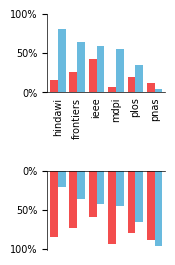

In [27]:
plotSidebySide(toPlot.query('Publisher!= "all"'), key='Publisher', width=3, saveFile=False)
plt.savefig('../figures/figure_1c.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 1d

In [30]:
editorsField = pd.read_csv(DATADIR + 'country_rep/EditorsField.tsv', sep='\t')
authorsField = pd.read_csv(DATADIR + 'country_rep/AuthorsField.tsv', sep='\t')

In [31]:
nineteenFields = pd.read_csv(DATADIR + 'Fields.tsv', sep='\t')
nineteenFields.shape

(19, 2)

In [32]:
nineteenFields.head()

,FID,FieldName
0,0,Medicine
1,1,Biology
2,2,Geology
3,3,Chemistry
4,4,Philosophy


In [33]:
def computeRepresentationByField(editors=editorsField, authors=authorsField):
    
    df = pd.DataFrame(columns=['iso', 'Over', 'p', 'EdiCount', 'AutCount', 'EdiTotal', 'AutTotal'])
    df['Over'] = df['Over'].astype(bool)
    
    for ind, row in nineteenFields.iterrows():
        
        field = row['FieldName']
        fid = row['FID']
    
        if field != 'all':
            subEdi = editors.query(f'FID == {fid}')
            subAut = authors.query(f'FID == {fid}')
        elif field == 'all':
            subEdi = editors.copy()
            subAut = authors.copy()

        ediTotal = subEdi.shape[0]
        autTotal = subAut.shape[0]
        
        if ediTotal==0 or autTotal==0: continue

        for country in editors.iso.unique():

            e = subEdi.query(f'iso == "{country}"').shape[0]
            a = subAut.query(f'iso == "{country}"').shape[0]

            test = fisher_exact([[e, ediTotal], [a, autTotal]])
            
            df = pd.concat([df, pd.DataFrame({
                'FieldName': field,
                'iso':country,
                'Over': e/ediTotal > a/autTotal,
                'p': test[1],
                'EdiCount': e,
                'AutCount': a,
                'EdiTotal': ediTotal,
                'AutTotal': autTotal
            }, index=[0])], ignore_index=True)
            
    df = df.assign(EdiPercent = lambda df: df.EdiCount/df.EdiTotal)
    df = df.assign(AutPercent = lambda df: df.AutCount/df.AutTotal)
    
    df = df.query('AutPercent > 0')
    df = df.assign(Relative = lambda df: df.EdiPercent/df.AutPercent)
    
    return df

In [34]:
%%time
df = computeRepresentationByField()

CPU times: user 2min 25s, sys: 1.8 s, total: 2min 27s
Wall time: 2min 27s


In [37]:
# only show the significant ones
toPlot = (
    df
    .query('p < 0.001')
    .merge(continents, on='iso')
    .merge(isoToC, on='iso')
    .merge(colorsDf, on='region')
)

toPlot.shape # 989

(989, 14)

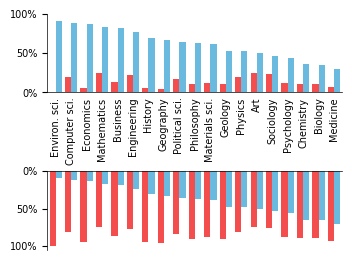

In [38]:
plotSidebySide(toPlot, width=7.5, saveFile=False)
plt.savefig('../figures/figure_1d.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 1e

In [39]:
topJournalISO = pd.read_csv(DATADIR + 'country_rep/TopJournalCountryRep.tsv',sep='\t')

In [40]:
%%time
def fisherRow(row):
    return fisher_exact([[row.EdiCount, row.EdiTotal], [row.AutCount, row.AutTotal]])[1]
    

topEditorCountToPlot = (
    
    topJournalISO
    
    .assign(p = lambda df: df.apply(fisherRow, axis=1))
    .assign(Over = lambda df: df.apply(lambda row: row.EdiCount/row.EdiTotal > row.AutCount/row.AutTotal, axis=1))
    
    .merge(continents, on='iso')
    .merge(isoToC, on='iso')
    .merge(colorsDf, on='region')
)
print(topEditorCountToPlot.shape)

(434, 13)
CPU times: user 9.09 s, sys: 52.6 ms, total: 9.14 s
Wall time: 9.12 s


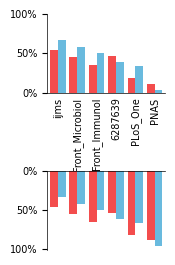

In [41]:
plotSidebySide(topEditorCountToPlot, key='Journal', width=3, saveFile=False)
plt.savefig('../figures/figure_1e.pdf', bbox_inches = 'tight', pad_inches = 0)